# Settings

In [120]:
USE_ALIGNZERO_GLOBAL = 0 
USE_ALIGNZERO_LOCAL = 0
USE_OFFSET = 0 
offset = 0.1
USE_BANDPASS = 1 
USE_NOTCH = 1
USE_ENVELOPE = 0
USE_ZSCORE = 0 
USE_SCALING = 0 

# USE_ALIGNZERO_GLOBAL = Substract the mean to each channel
# USE_ALIGNZERO_LOCAL 
# USE_OFFSET = Generate more windows with offset
# offset 
# USE_BANDPASS = Filter with bandpass (window by window)
# USE_ZSCORE = Filter with zscore (window by window)
# USE_SCALING = Use feature scaling

print("Settings updated")

Settings updated


# Get raw data

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ------- Get information from 7 classes recordings
path1 = "C:/Quick_Disk/tonge_project/data/Recordings_7_classes/data.csv" 
path2 = "C:/Quick_Disk/tonge_project/data/Recordings_7_classes2/data.csv" 
path3 = "C:/Quick_Disk/tonge_project/data/Recordings_7_classes3/data.csv" 
path4 = "C:/Quick_Disk/tonge_project/data/Recordings_7_classes4/data.csv" 

df1 = pd.read_csv(path1, sep='\t', skiprows=5, engine='python')
print("Read df1")
df2 = pd.read_csv(path2, sep='\t', skiprows=5, engine='python')
print("Read df2")
df3 = pd.read_csv(path3, sep='\t', skiprows=5, engine='python')
print("Read df3")
df4 = pd.read_csv(path4, sep='\t', skiprows=5, engine='python')
print("Read df4")

df1.columns = [f"ch_{i}" for i in range(df1.shape[1])]
df2.columns = [f"ch_{i}" for i in range(df2.shape[1])]
df3.columns = [f"ch_{i}" for i in range(df3.shape[1])]
df4.columns = [f"ch_{i}" for i in range(df4.shape[1])]

# Train data
df_7classes = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True)
combined_df = df_7classes

# Test data
test_df = df4

print(f"Final combined data shape: {combined_df.shape}")

if USE_ALIGNZERO_GLOBAL == 1:
    channels = ["ch_1", "ch_2", "ch_3"]
    channel_means = combined_df[channels].mean()
    for ch in channels:
        combined_df[ch] = combined_df[ch] - channel_means[ch]


Read df1
Read df2
Read df3
Read df4
Final combined data shape: (356265, 24)


# Create windows

## Train windows

In [121]:
import numpy as np
import os
import pandas as pd  

# Class labels
windowed_data = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}

# ----------- Windows from 7 classes recordings
annotations_path1 = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\7_classes_annotations1.csv"
annotations_path2 = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\7_classes_annotations2.csv"
annotations_path3 = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\7_classes_annotations3.csv"

annotations1 = pd.read_csv(annotations_path1, header=0, names=['class', 'timestamp'])
annotations2 = pd.read_csv(annotations_path2, header=0, names=['class', 'timestamp'])
annotations3 = pd.read_csv(annotations_path3, header=0, names=['class', 'timestamp'])

annotations = pd.concat([annotations1, annotations2, annotations3], axis=0).reset_index(drop=True)
annotations['timestamp'] = pd.to_numeric(annotations['timestamp'], errors='coerce')
# ----------------

windowed_data_7_classes = {'l': [], 'k': [], 'r': [], 'e': [], 'f': [], 'n': [], 's': [], 'c': []}
window_size_seconds = 0.5

offsets = [0]
if USE_OFFSET == 1:
    offsets = [0, -2*offset]

for idx, row in annotations.iterrows():
    label = row['class']
    base_time = row['timestamp']
    
    for shift in offsets:
        start_time = base_time + shift
        end_time = start_time + window_size_seconds

        idxs = (combined_df['ch_22'] >= start_time) & (combined_df['ch_22'] < end_time)

        if not any(idxs):
            print(f"No data for window starting at {start_time:.3f} (label={label}, offset={shift:+.1f}s)")
            continue

        window_data = {}
        for ch in ['ch_1', 'ch_2', 'ch_3']:
            window_data[ch] = combined_df[ch][idxs]

        windowed_data_7_classes[label].append({
            'ch_1': window_data.get('ch_1', []),
            'ch_2': window_data.get('ch_2', []),
            'ch_3': window_data.get('ch_3', []),
        })

print("Acquired windows for 6 classes")

print(f"Label l:")
for i, window_dict in enumerate(windowed_data_7_classes['l'][:10]):
    # Get the length of ch_1 series or list
    size = len(window_dict['ch_1'])
    print(f"  Window {i+1}: size = {size} samples")

# ----------- Combine windows

windowed_data_7_map = {
    'l': 'l',
    'k': 'lf',
    'r': 'r',
    'e': 'rf',
    'f': 'f',
    'n': 'n',
    's': 's'
}

class_map = {
    'left': 'l',
    'left_front': 'lf',
    'front': 'f',
    'right_front': 'rf',
    'right': 'r',
    'swallow': 's',
    'none': 'n'
}

for src_label, tgt_label in windowed_data_7_map.items():
    for window_dict in windowed_data_7_classes[src_label]:
        # Convert dict of series to (N, 3) array
        ch1 = window_dict['ch_1'].to_numpy() if hasattr(window_dict['ch_1'], 'to_numpy') else np.array(window_dict['ch_1'])
        ch2 = window_dict['ch_2'].to_numpy() if hasattr(window_dict['ch_2'], 'to_numpy') else np.array(window_dict['ch_2'])
        ch3 = window_dict['ch_3'].to_numpy() if hasattr(window_dict['ch_3'], 'to_numpy') else np.array(window_dict['ch_3'])

        # Stack as (N, 3) array
        arr = np.column_stack([ch1, ch2, ch3])
        
        windowed_data[tgt_label].append(arr)


print("---- Train windows")
for long_label, short_label in class_map.items():
    print(f"Class '{short_label}': {len(windowed_data[short_label])} windows.")


Acquired windows for 6 classes
Label l:
  Window 1: size = 125 samples
  Window 2: size = 125 samples
  Window 3: size = 125 samples
  Window 4: size = 125 samples
  Window 5: size = 125 samples
  Window 6: size = 126 samples
  Window 7: size = 125 samples
  Window 8: size = 125 samples
  Window 9: size = 125 samples
  Window 10: size = 125 samples
---- Train windows
Class 'l': 36 windows.
Class 'lf': 34 windows.
Class 'f': 36 windows.
Class 'rf': 35 windows.
Class 'r': 35 windows.
Class 's': 40 windows.
Class 'n': 47 windows.


## Test windows

In [122]:
import numpy as np
import os
import pandas as pd  

# Class labels
windowed_data_test = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []} 

# ----------- Windows from 7 classes recordings
annotations_path4 = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\7_classes_annotations4.csv"
annotations4 = pd.read_csv(annotations_path4, header=0, names=['class', 'timestamp'])

annotations_test = annotations4
annotations_test['timestamp'] = pd.to_numeric(annotations_test['timestamp'], errors='coerce')

windowed_data_7_classes_test = {'l': [], 'k': [], 'r': [], 'e': [], 'f': [], 'n': [], 's': [], 'c': []}
window_size_seconds = 0.5

offsets = [0]
if USE_OFFSET == 1:
    offsets = [0, -2*offset]

for idx, row in annotations_test.iterrows():
    label = row['class']
    base_time = row['timestamp']
    
    for shift in offsets:
        start_time = base_time + shift
        end_time = start_time + window_size_seconds

        idxs = (test_df['ch_22'] >= start_time) & (test_df['ch_22'] < end_time)

        if not any(idxs):
            print(f"No data for window starting at {start_time:.3f} (label={label}, offset={shift:+.1f}s)")
            continue

        window_data = {}
        for ch in ['ch_1', 'ch_2', 'ch_3']:
            window_data[ch] = test_df[ch][idxs]

        windowed_data_7_classes_test[label].append({
            'ch_1': window_data.get('ch_1', []),
            'ch_2': window_data.get('ch_2', []),
            'ch_3': window_data.get('ch_3', []),
        })

print("Acquired windows for 6 classes")

print(f"Label l:")
for i, window_dict in enumerate(windowed_data_7_classes_test['l'][:10]):
    # Get the length of ch_1 series or list
    size = len(window_dict['ch_1'])
    print(f"  Window {i+1}: size = {size} samples")

# ----------- Combine windows

for src_label, tgt_label in windowed_data_7_map.items():
    for window_dict in windowed_data_7_classes_test[src_label]:
        # Convert dict of series to (N, 3) array
        ch1 = window_dict['ch_1'].to_numpy() if hasattr(window_dict['ch_1'], 'to_numpy') else np.array(window_dict['ch_1'])
        ch2 = window_dict['ch_2'].to_numpy() if hasattr(window_dict['ch_2'], 'to_numpy') else np.array(window_dict['ch_2'])
        ch3 = window_dict['ch_3'].to_numpy() if hasattr(window_dict['ch_3'], 'to_numpy') else np.array(window_dict['ch_3'])

        # Stack as (N, 3) array
        arr = np.column_stack([ch1, ch2, ch3])
        
        windowed_data_test[tgt_label].append(arr)


print("---- Test windows")
for long_label, short_label in class_map.items():
    print(f"Class '{short_label}': {len(windowed_data_test[short_label])} windows.")


Acquired windows for 6 classes
Label l:
  Window 1: size = 125 samples
  Window 2: size = 125 samples
  Window 3: size = 125 samples
  Window 4: size = 125 samples
  Window 5: size = 125 samples
---- Test windows
Class 'l': 5 windows.
Class 'lf': 5 windows.
Class 'f': 5 windows.
Class 'rf': 5 windows.
Class 'r': 5 windows.
Class 's': 7 windows.
Class 'n': 5 windows.


## Plot raw windows (only Train)

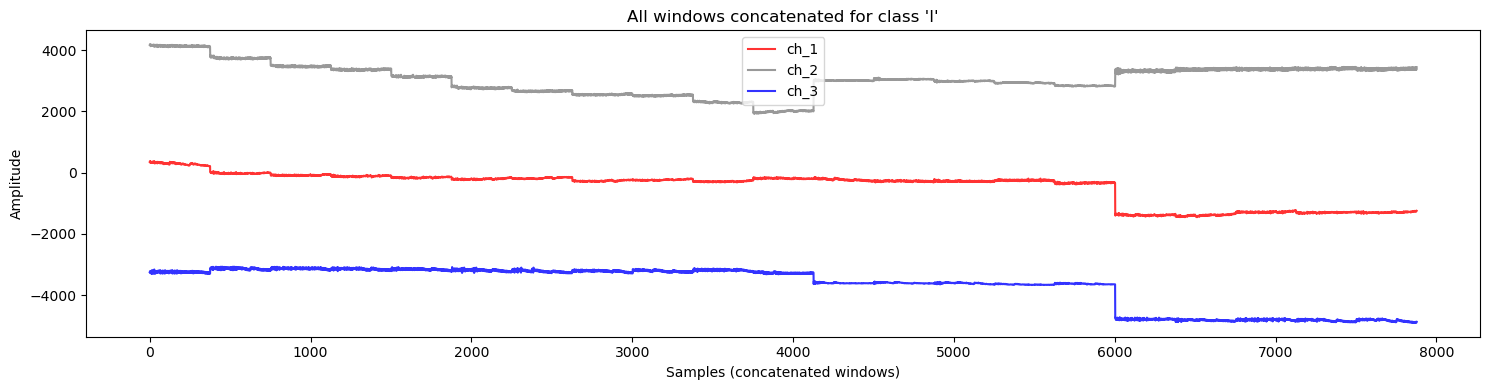

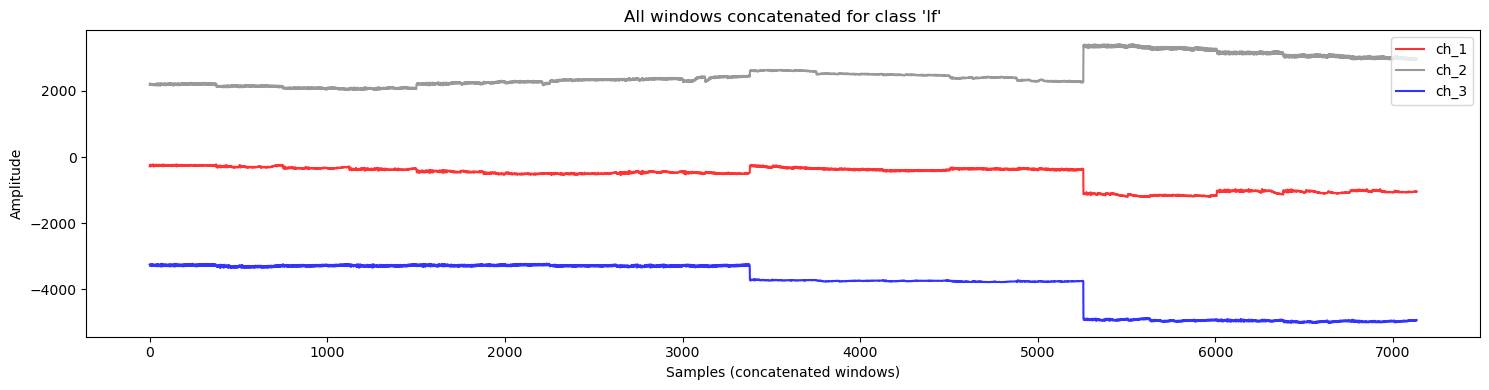

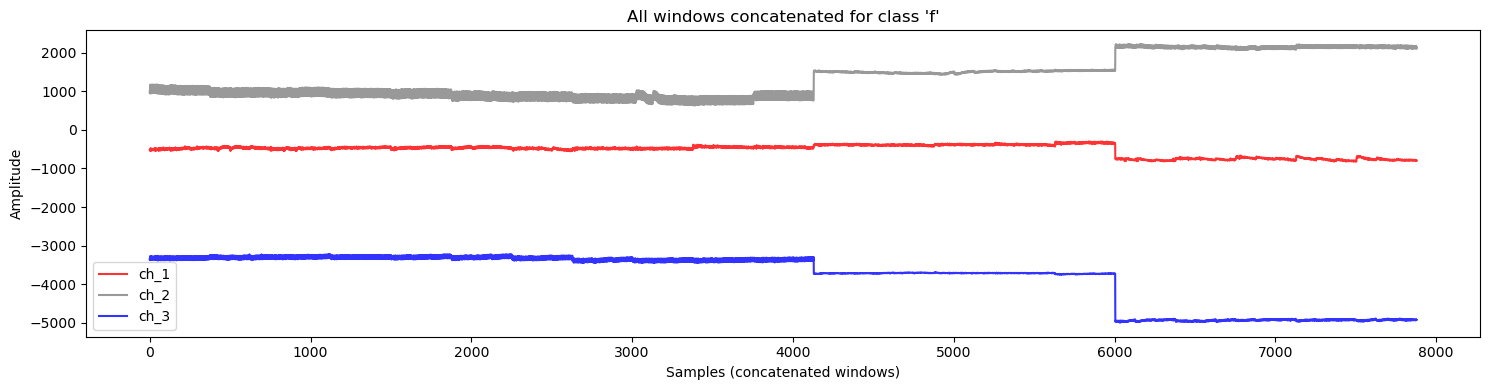

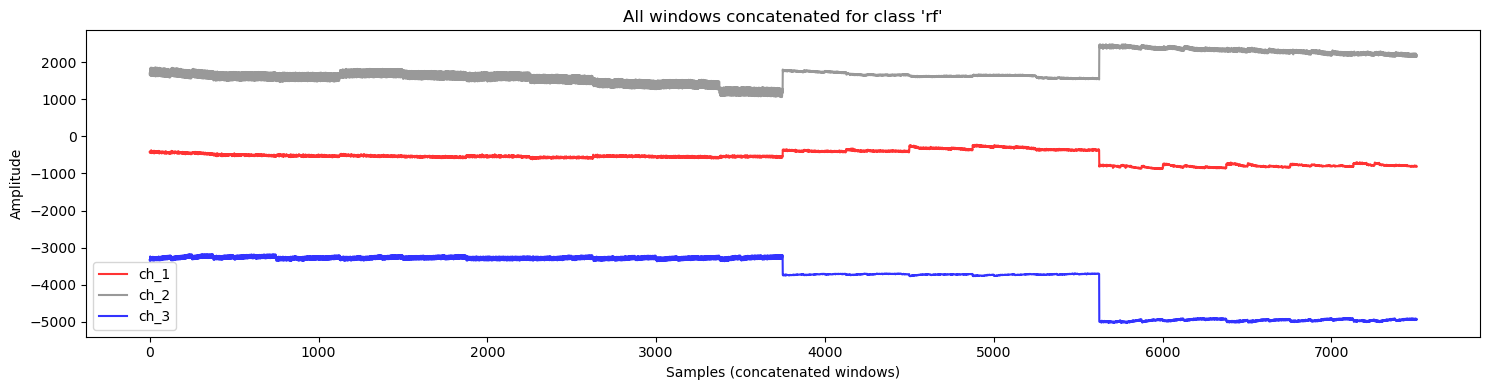

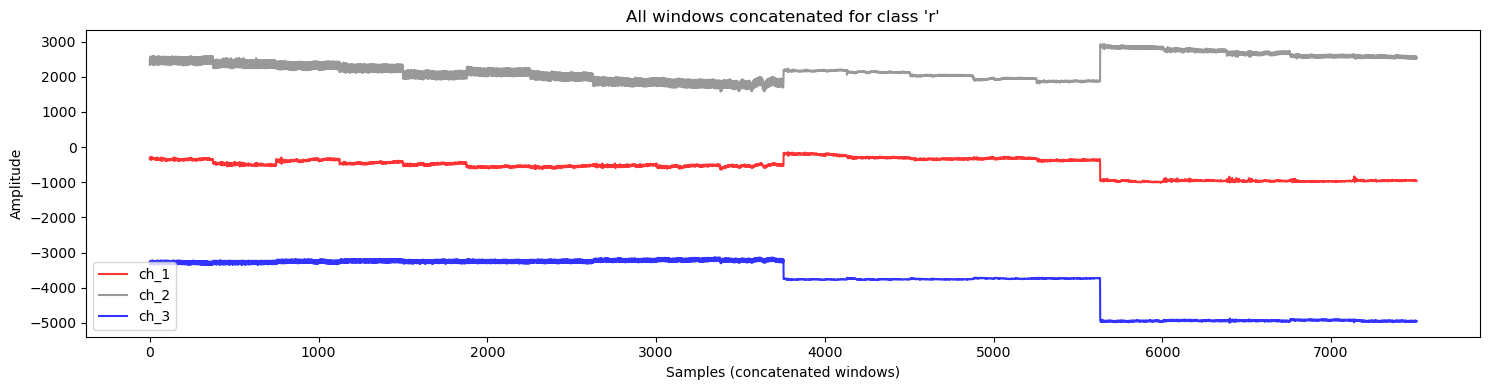

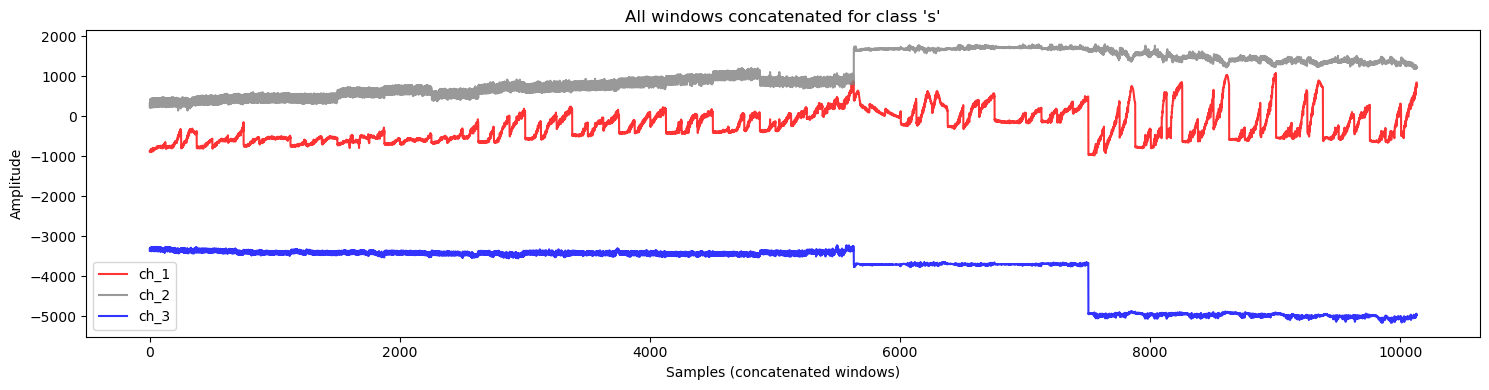

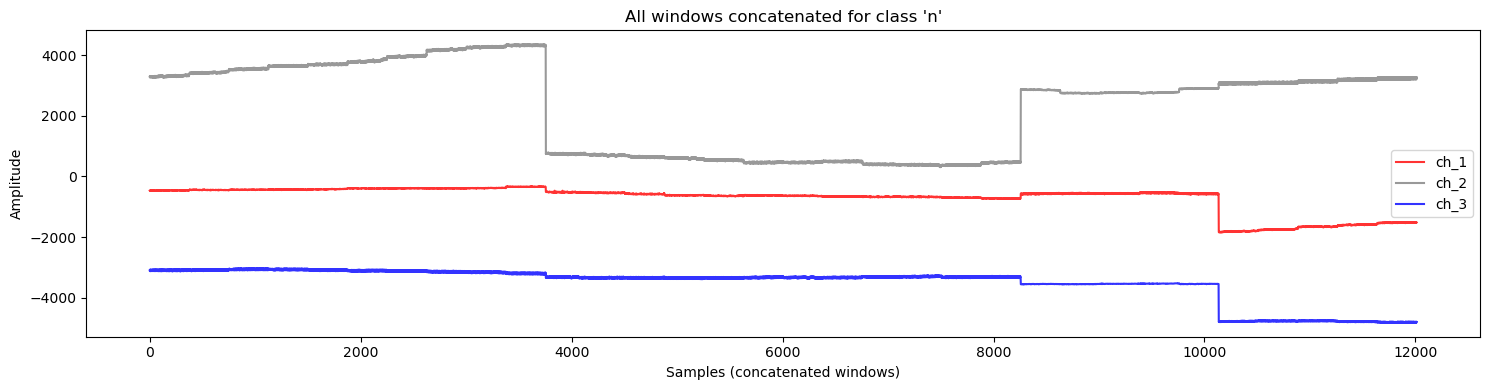

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

for class_label, windows in windowed_data.items():
    if not windows:
        print(f"No windows for class '{class_label}', skipping plot.")
        continue
    
    # Concatenate all windows along time axis (axis=0)
    # Each window shape: (samples, 3 channels)
    concatenated = np.vstack(windows)  # shape: (num_windows * samples, 3)
    
    plt.figure(figsize=(15, 4))
    
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    plt.title(f"All windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Filter windows

In [147]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut=5.0, highcut=50.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def high_pass_filter(signal, cutoff=0.1, fs=250, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def notch_filter(signal, freq=50.0, fs=250, quality=30):
    nyquist = 0.5 * fs
    norm_freq = freq / nyquist
    b, a = iirnotch(norm_freq, quality)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def compute_envelope(signal, fs=250, cutoff=5.0):
    rectified = np.abs(signal)
    b, a = butter(4, cutoff / (0.5 * fs), btype='low')
    envelope = filtfilt(b, a, rectified)
    return envelope

def filter_dataset(dataset, dataset_name=""):
    filtered_dataset = {}

    for class_label, windows in dataset.items():
        if not windows:
            print(f"No windows for class '{class_label}' in {dataset_name}, skipping filter.")
            continue
        
        fwindows = []
        for window in windows:
            if window.shape[0] <= 30:
                print(f"Skipping short window of length {window.shape[0]} for class '{class_label}'")
                continue
            one_window = window.copy()
            for i in range(window.shape[1]): 
                if i in [0, 1, 2]:  # Filter ONLY CHANNELS 1, 2 AND 3

                    if USE_NOTCH == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])
                        
                    if USE_BANDPASS == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])

                    if USE_ENVELOPE == 1:
                        one_window[:, i] = compute_envelope(one_window[:, i])

                    if USE_ZSCORE == 1:
                        mean = one_window[:, i].mean()
                        std = one_window[:, i].std()
                        if std == 0:
                            std = 1
                        one_window[:, i] = (one_window[:, i] - mean) / std
                        
                    if USE_ALIGNZERO_LOCAL == 1:
                        mean = one_window[:, i].mean()
                        one_window[:, i] = one_window[:, i] - mean
                        
            fwindows.append(one_window)

        filtered_dataset[class_label] = fwindows

    print(f"Filtering completed for {dataset_name}")
    return filtered_dataset

# Filter train and test datasets
filtered = filter_dataset(windowed_data, "train set")
filtered_test = filter_dataset(windowed_data_test, "test set")


Filtering completed for train set
Filtering completed for test set


## Plot filtered windows (only Train)

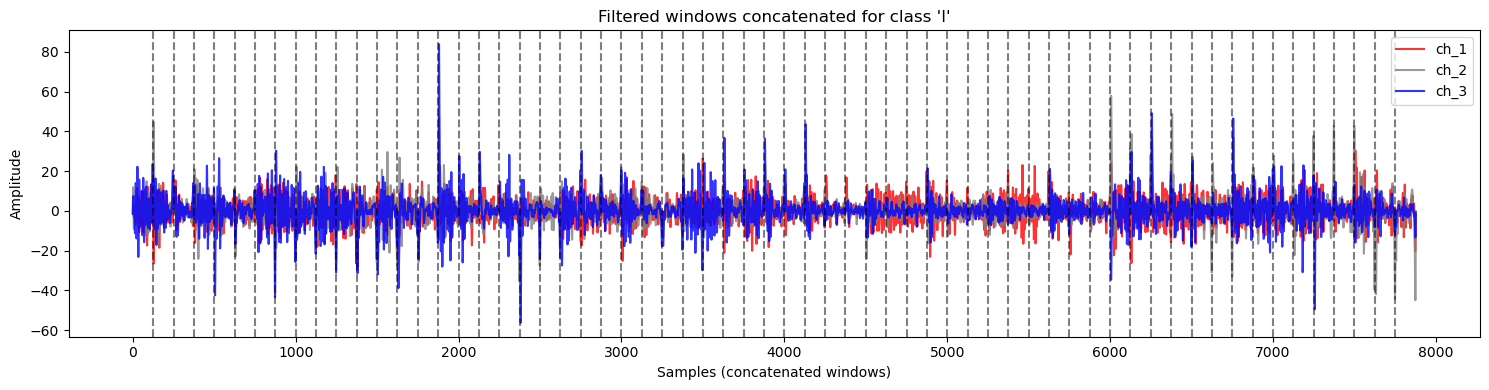

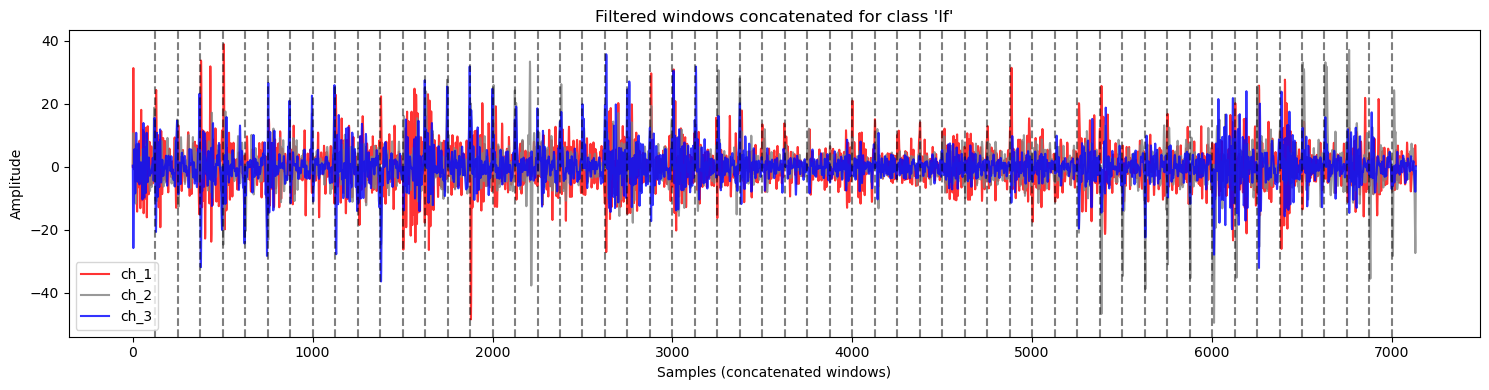

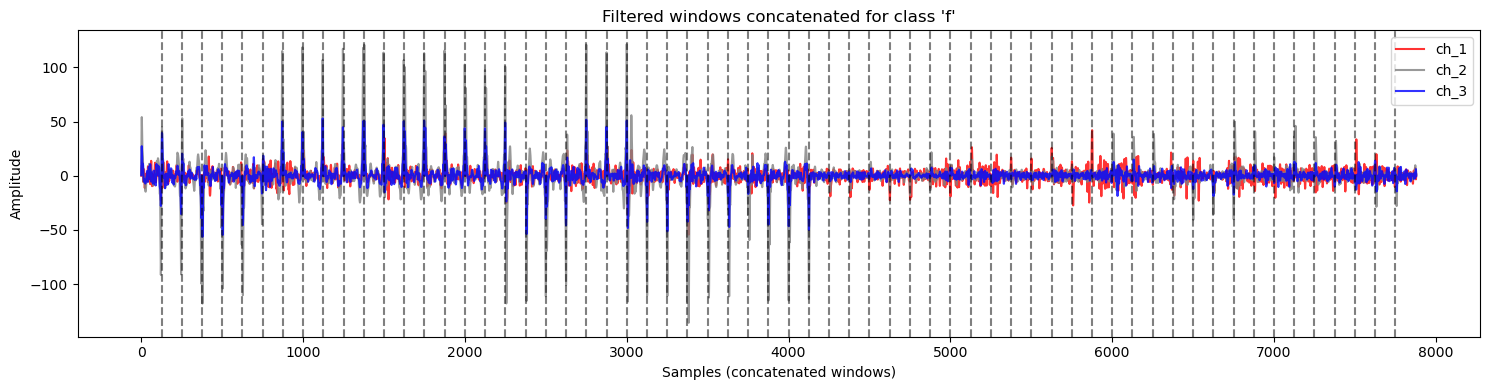

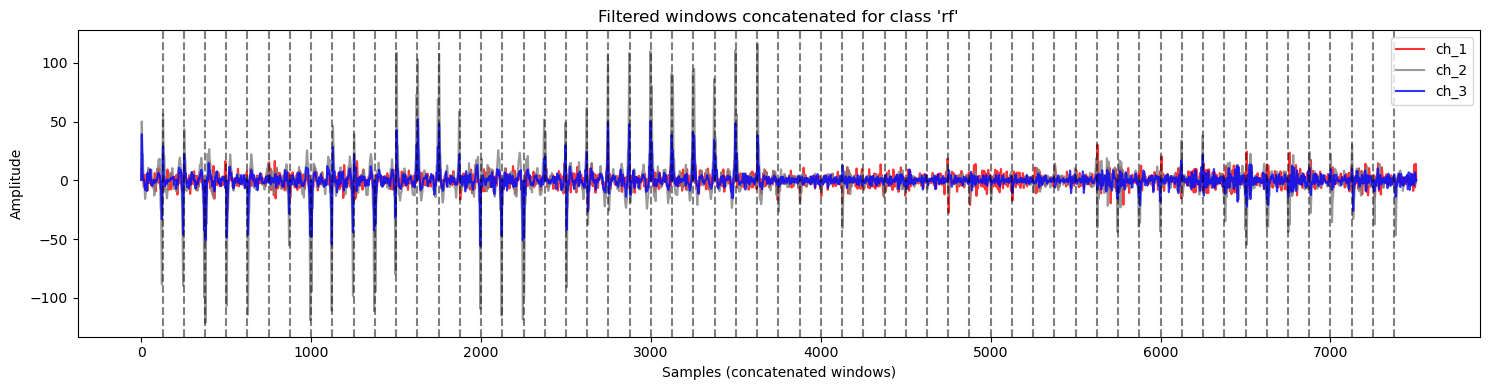

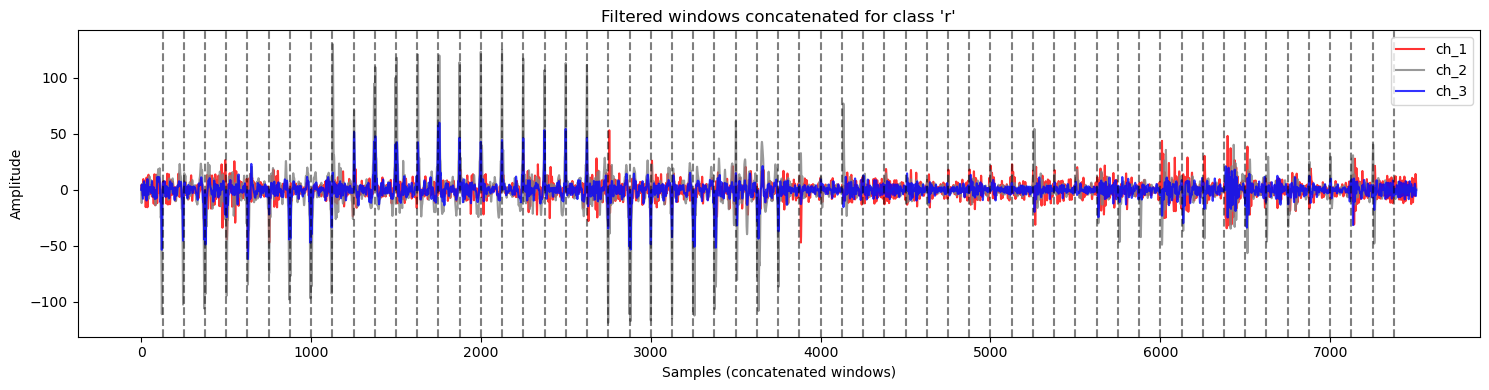

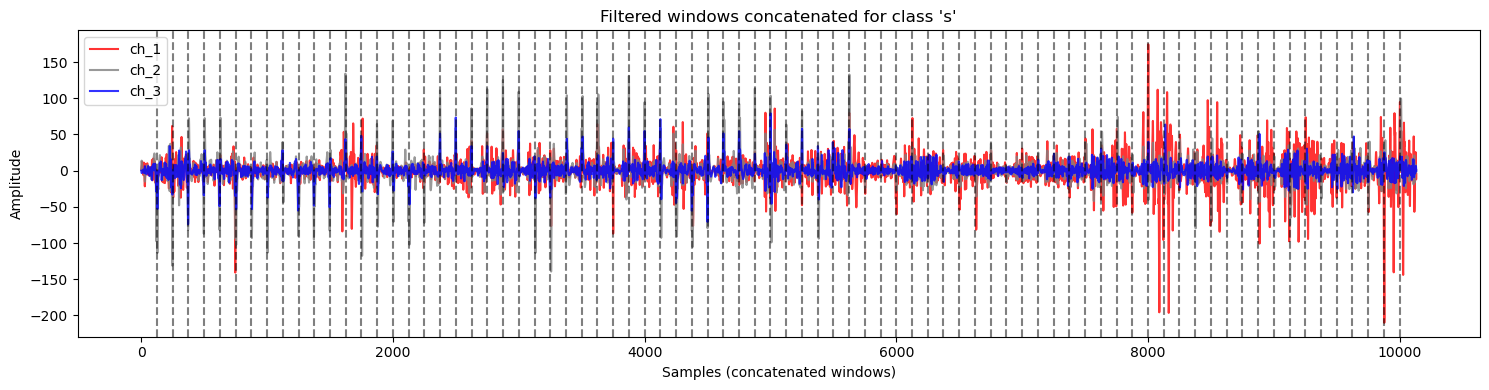

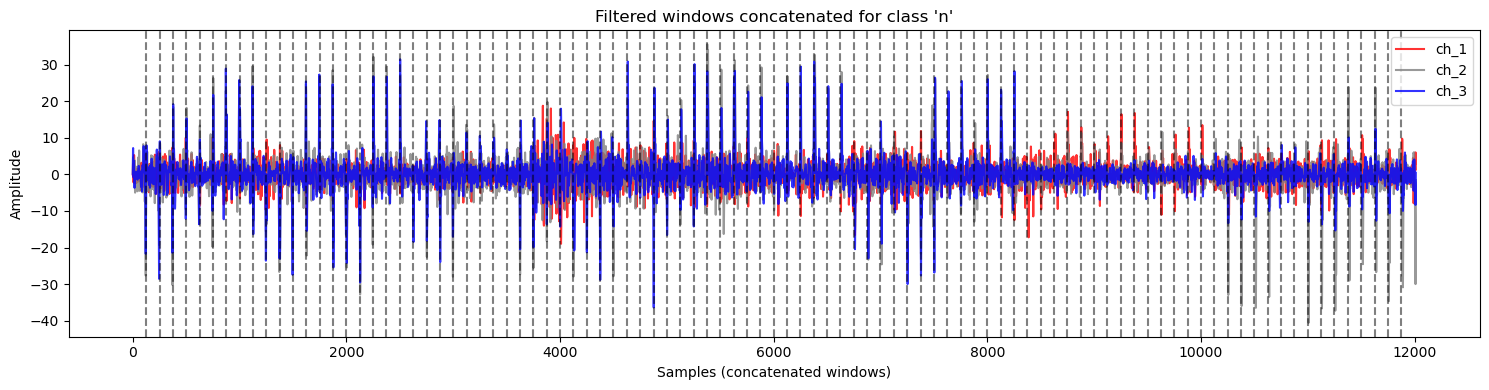

In [92]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot filtered windows (only Test)

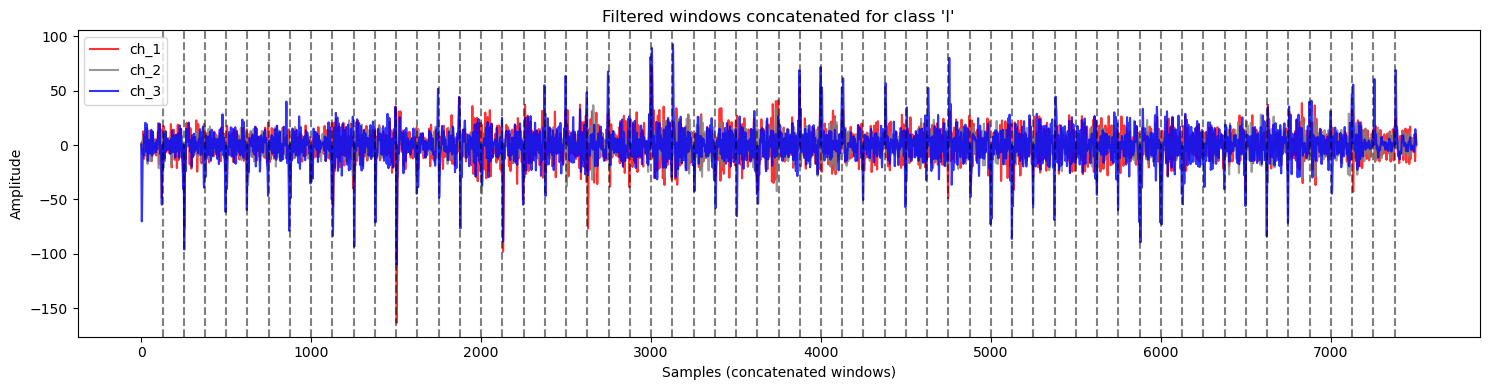

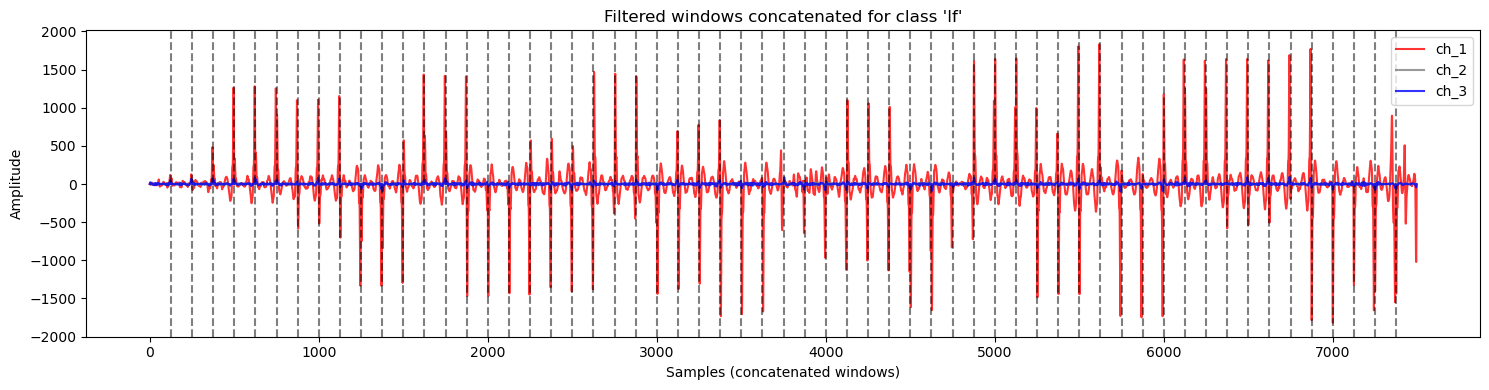

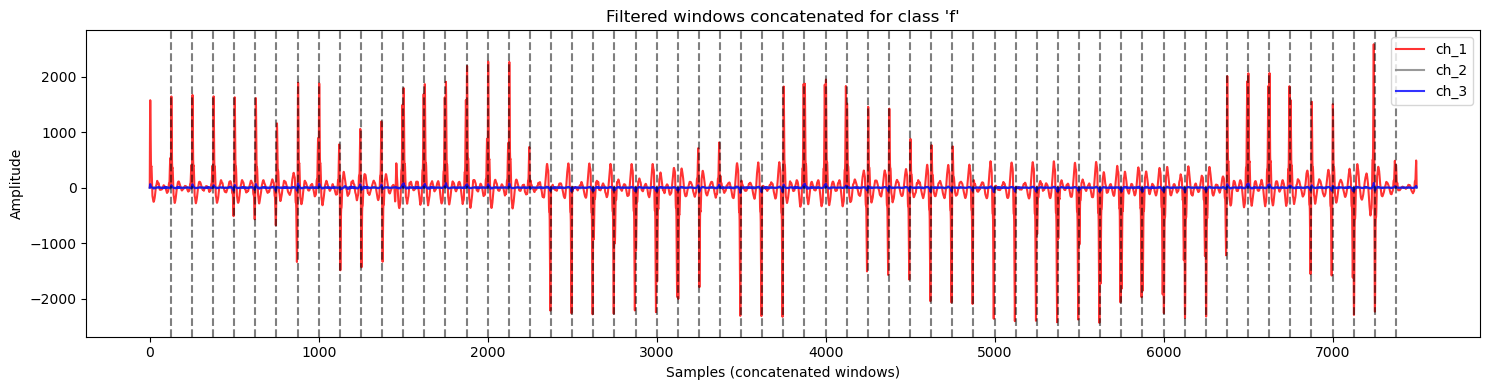

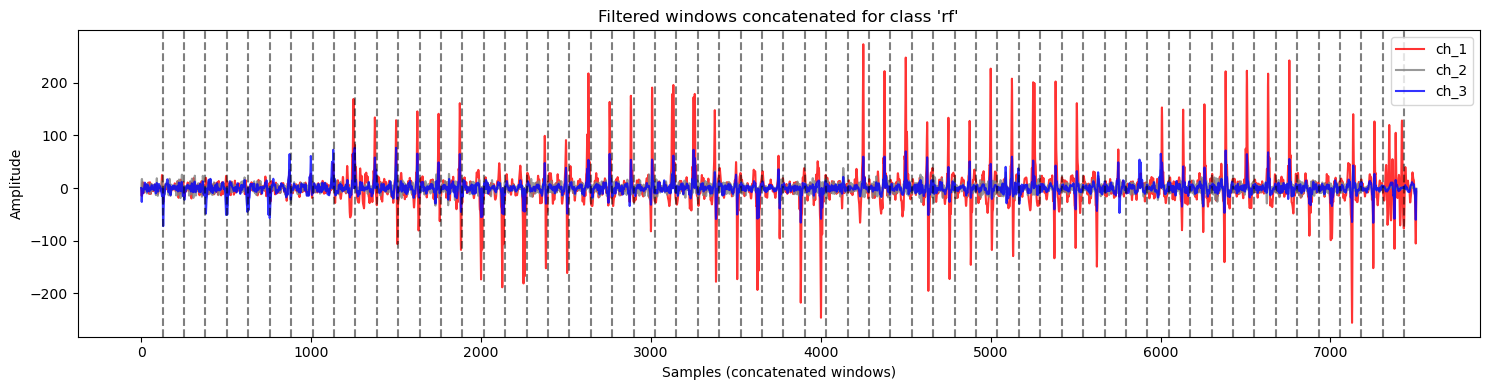

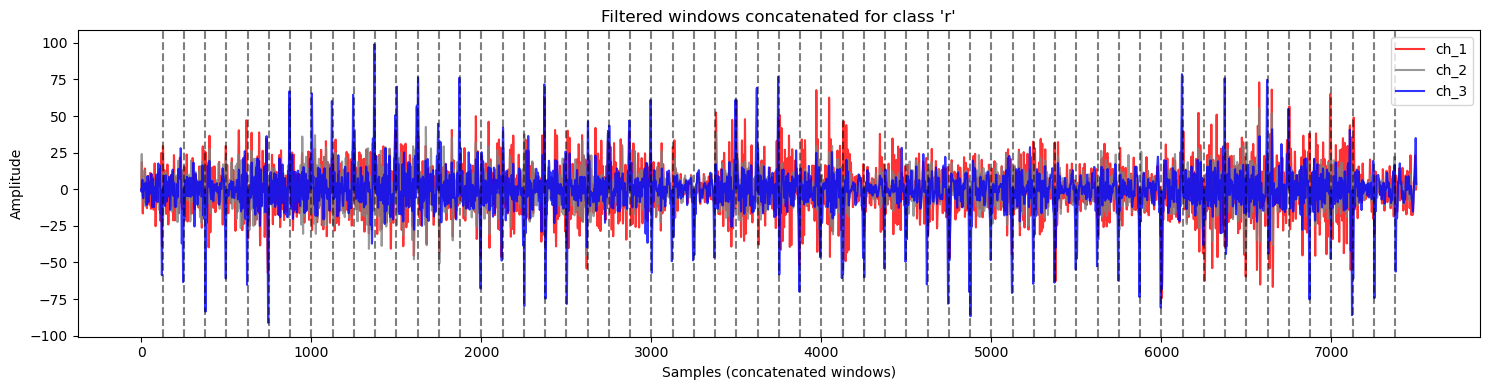

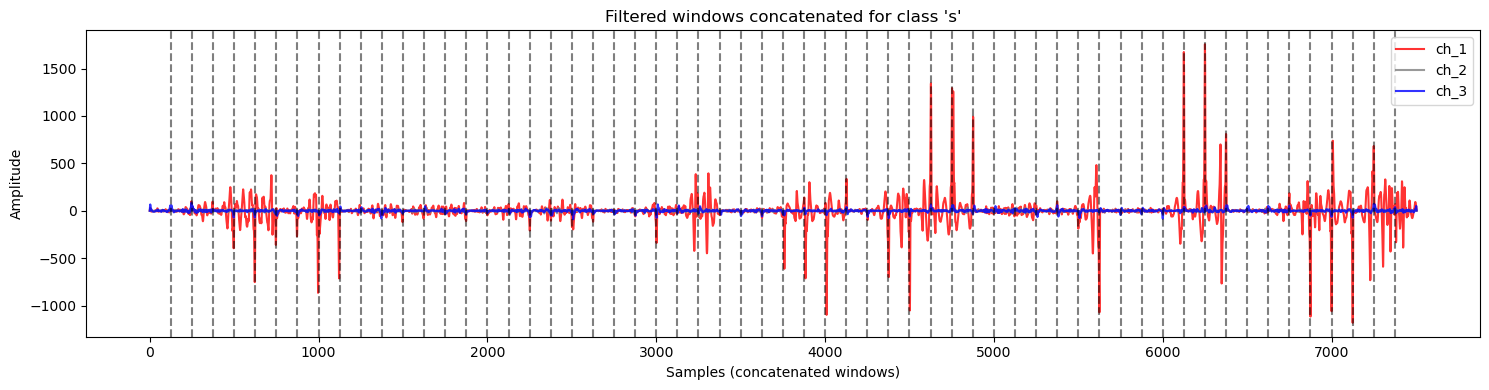

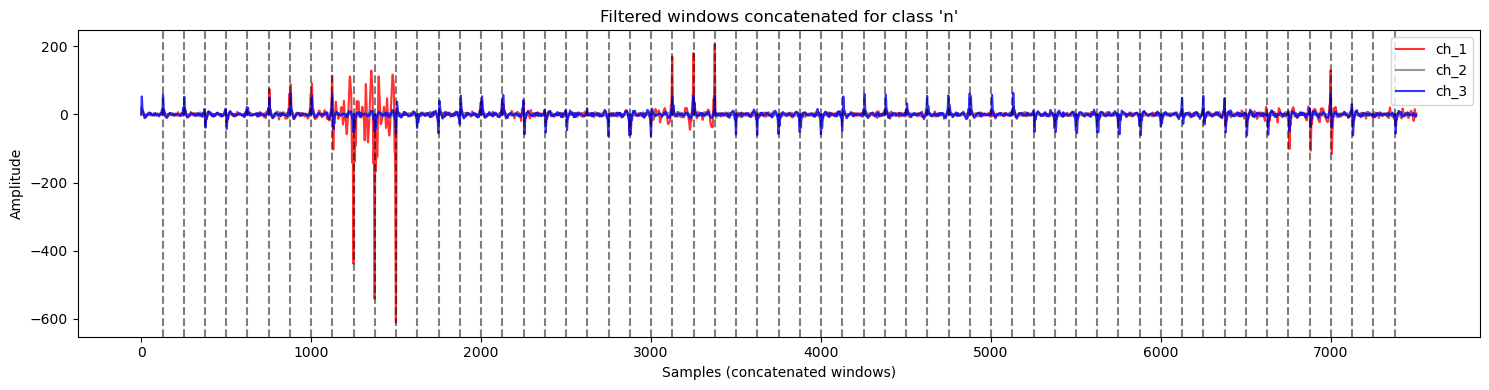

In [93]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered_test.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Feature extraction

In [148]:
import numpy as np
import pandas as pd

# -------------- Feature functions 
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iav(signal):
    return np.sum(np.abs(signal))

def rms_signed_difference(signal):
    mean_val = np.mean(signal)
    diff = signal - mean_val
    return np.sqrt(np.mean(diff**2))

def mean_frequency(signal, fs=250):
    # Compute FFT
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    power = fft_vals ** 2
    if np.sum(power) == 0:
        return 0
    mf = np.sum(freqs * power) / np.sum(power)
    return mf

# -------------------

class_labels = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
channels = ['ch_1', 'ch_2', 'ch_3']
feature_names = ['RMS', 'RMS_SD', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV']

def extract_features(filtered_data):
    features = []
    labels = []

    for label in class_labels:
        for window in filtered_data.get(label, []):
            feats = []
            for ch_idx in range(len(channels)):
                ch_signal = window[:, ch_idx]
                feats.append(rms(ch_signal))
                feats.append(rms_signed_difference(ch_signal))
                feats.append(zero_crossings(ch_signal))
                feats.append(waveform_length(ch_signal))
                feats.append(mav(ch_signal))
                feats.append(np.std(ch_signal))
                feats.append(np.var(ch_signal))
                feats.append(iav(ch_signal))
                
            features.append(feats)
            labels.append(label)

    cols = []
    for ch in channels:
        for feat_name in feature_names:
            cols.append(f"{ch}_{feat_name}")

    X = pd.DataFrame(features, columns=cols)
    y = pd.Series(labels, name='label')
    return X, y

# Extract features for train and test
X, y = extract_features(filtered)
Xt, yt = extract_features(filtered_test)

print("--- Train:")
print(X.head())
print(y.head())

print("\n--- Test:")
print(Xt.head())
print(yt.head())


--- Train:
    ch_1_RMS  ch_1_RMS_SD  ch_1_ZC      ch_1_WL   ch_1_MAV   ch_1_STD  \
0  15.280789    15.249580       36  1178.274501  11.629071  15.249580   
1  10.569764    10.567646       30   748.183773   8.243306  10.567646   
2  11.617178    11.616496       32   949.829488   9.579848  11.616496   
3  18.925877    18.699857       27  1176.113671  13.575091  18.699857   
4  31.231514    30.859117       21  1029.135470  16.103429  30.859117   

     ch_1_VAR     ch_1_IAV   ch_2_RMS  ch_2_RMS_SD  ...    ch_2_VAR  \
0  232.549687  1453.633891  12.755414    12.731856  ...  162.100153   
1  111.675135  1030.413294  10.390781    10.336063  ...  106.834193   
2  134.942977  1197.480978  11.046287    11.006572  ...  121.144629   
3  349.684642  1696.886314  11.045482    11.003231  ...  121.071103   
4  952.285113  2012.928607  19.474761    19.071916  ...  363.737991   

      ch_2_IAV   ch_3_RMS  ch_3_RMS_SD  ch_3_ZC      ch_3_WL   ch_3_MAV  \
0  1200.157861  24.383901    24.055115       38 

# Classification

## Random Forest Tree

Random Forest Test Accuracy: 0.759


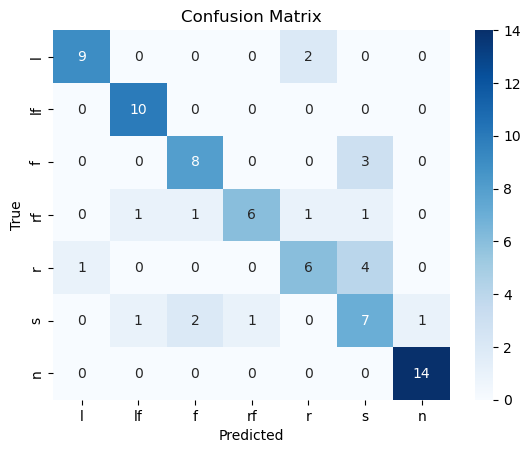

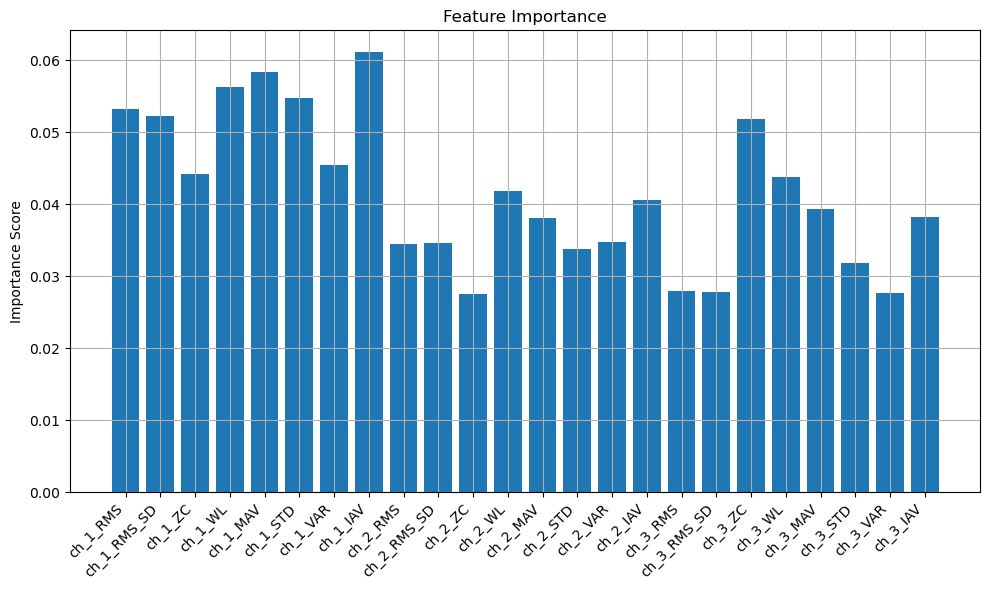

In [149]:
# ------------------------------- RANDOM FOREST TREE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_RF = StandardScaler()
X_train_scaled_array = scaler_RF.fit_transform(X_train)
X_test_scaled_array = scaler_RF.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_RF = RandomForestClassifier(n_estimators=500, random_state=42)
if USE_SCALING == 1:
    clf_RF.fit(X_train_scaled, y_train) # with scaling
    y_pred = clf_RF.predict(X_test_scaled)
else:
    clf_RF.fit(X_train, y_train)
    y_pred = clf_RF.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'feat{i}' for i in range(X.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model and scaler
#joblib.dump(clf_RF, "6_classes_rf.pkl")
#joblib.dump(scaler_RF, "6_classes_scaler_rf.pkl")


## PCA 

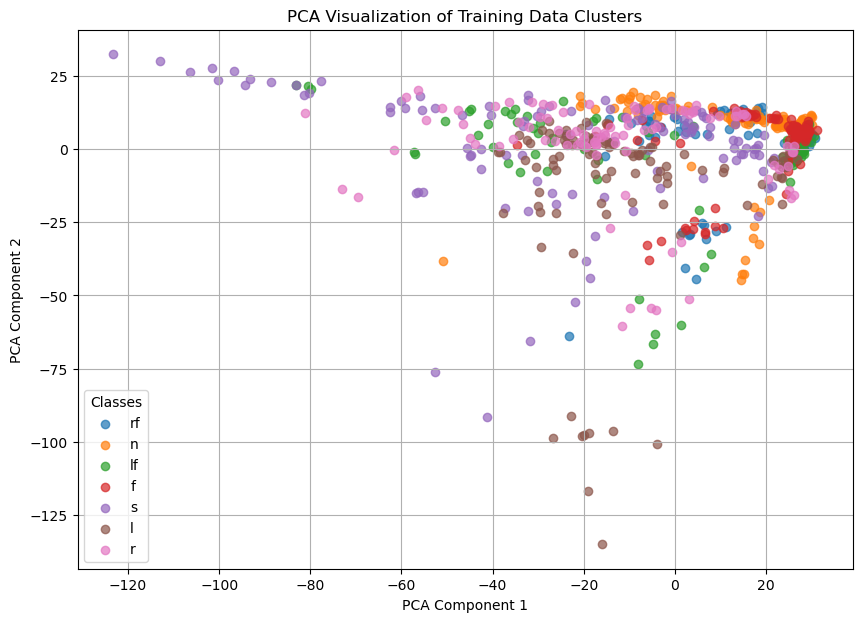

In [29]:
from sklearn.decomposition import PCA

# 2.5 PCA for visualization (2D)
pca = PCA(n_components=2)

if USE_SCALING == 1:
    X_train_pca = pca.fit_transform(X_train_scaled)
else:
    X_train_pca = pca.fit_transform(X_train)

# Plot
plt.figure(figsize=(10, 7))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Training Data Clusters')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


## SVM

SVM Test Accuracy: 0.698


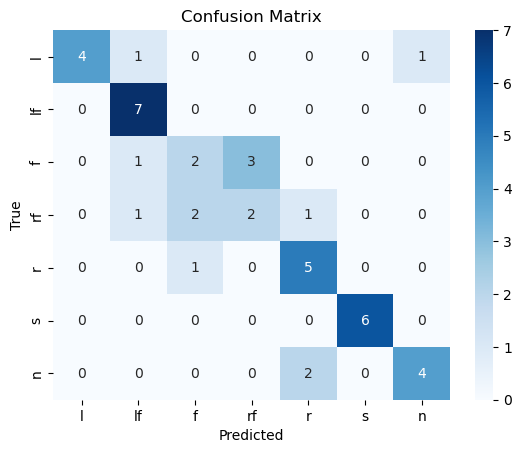

In [50]:
# ----------------------------- SUPPORT VECTOR MACHINE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train 
clf_SVM = SVC(kernel='linear', C=1.0, gamma='scale', class_weight='balanced')
clf_SVM.fit(X_train_scaled, y_train)

# 4. Predict
y_pred = clf_SVM.predict(X_test_scaled)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"SVM Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_SVM, "7_classes_svm.pkl")
#joblib.dump(scaler, "scaler_svm.pkl")


# Test

## Random Forest Tree

Random Forest Test Accuracy: 0.514


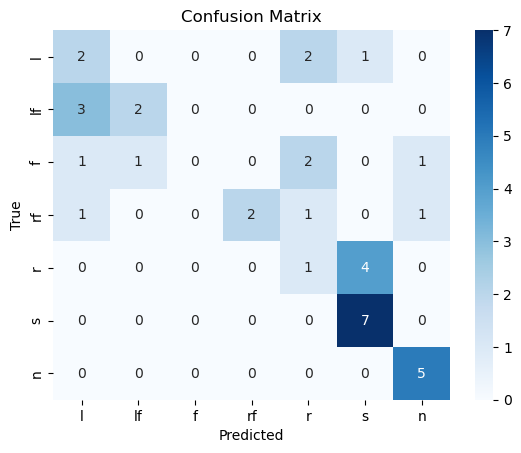

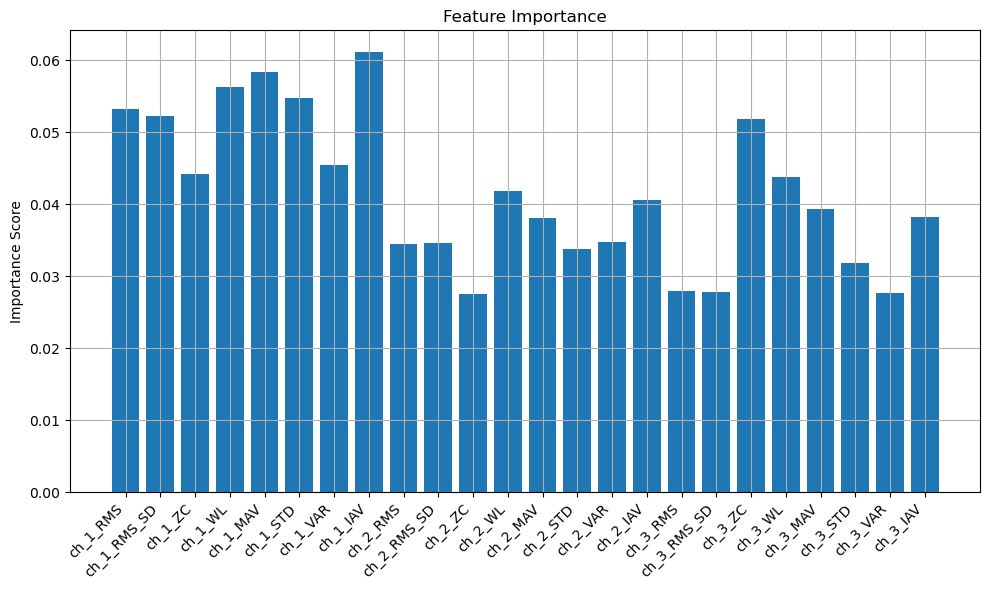

In [150]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_RF.predict(Xt_scaled)
else:
    y_pred = clf_RF.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()
